In [1]:
import pandas as pd
import numpy as np
import pyagrum as gum
import pyagrum.lib.notebook as gnb

# Show all columns
pd.set_option('display.max_columns', None)

# variable information 
vars_df = pd.read_csv('Dataset/processed_credit.csv')
vars_df

CheckingAccount Duration                               CreditHistory  \
0               lt0    Short  Critical account / other credits elsewhere   
1            0to200   Medium         Existing credits paid duly till now   
2       No Checking    Short  Critical account / other credits elsewhere   
3               lt0   Medium         Existing credits paid duly till now   
4               lt0    Short             Delay in paying off in the past   
..              ...      ...                                         ...   
995     No Checking    Short         Existing credits paid duly till now   
996             lt0   Medium         Existing credits paid duly till now   
997     No Checking    Short         Existing credits paid duly till now   
998             lt0   Medium         Existing credits paid duly till now   
999          0to200   Medium  Critical account / other credits elsewhere   

                 Purpose CreditAmount        SavingsAccount EmploymentSince  \
0       radio/television          Low  unknown / no savings       ge7 years   
1       radio/television          Low              lt100 DM      1to4 years   
2              education          Low              lt100 DM      4to7 years   
3    furniture/equipment       Medium              lt100 DM      4to7 years   
4              car (new)          Low              lt100 DM      1to4 years   
..                   ...          ...                   ...             ...   
995  furniture/equipment          Low              lt100 DM      4to7 years   
996           car (used)          Low              lt100 DM      1to4 years   
997     radio/television          Low              lt100 DM       ge7 years   
998     radio/television          Low              lt100 DM      1to4 years   
999           car (used)          Low           100to500 DM      unemployed   

     InstallmentRate                   PersonalStatusSex OtherDebtors  \
0                  4                        male: single         none   
1                  2  female: divorced/separated/married         none   
2                  2                        male: single         none   
3                  2                        male: single    guarantor   
4                  3                        male: single         none   
..               ...                                 ...          ...   
995                3  female: divorced/separated/married         none   
996                4            male: divorced/separated         none   
997                4                        male: single         none   
998                4                        male: single         none   
999                3                        male: single         none   

     ResidenceSince                                   Property     Age  \
0                 4                                real estate     Old   
1                 2                                real estate   Young   
2                 3                                real estate  Middle   
3                 4  building society savings / life insurance  Middle   
4                 4                      unknown / no property  Middle   
..              ...                                        ...     ...   
995               4                                real estate   Young   
996               4  building society savings / life insurance  Middle   
997               4                               car or other  Middle   
998               4                      unknown / no property   Young   
999               4                               car or other   Young   

    OtherInstallmentPlans   Housing  ExistingCredits  \
0                    none       own                2   
1                    none       own                1   
2                    none       own                1   
3                    none  for free                1   
4                    none  for free                2   
..                    ...       ...     

# Open a saved Bayesian network

In [2]:
import pyagrum.lib.notebook as gnb
import pyagrum as gum

filepath = 'BNs/GermanCreditManual.bif'
bn = gum.loadBN(filepath)
bn

(pyagrum.BayesNet@0000023AB438A7A0) BN{nodes: 26, arcs: 36, domainSize: 10^13.7638, dim: 3736, mem: 55Ko 912o}

Populate random variable values with dataframe column value ranges

In [3]:
# Find observed and unobserved variables
bn_vars = set(bn.names())
df_vars = set(vars_df.columns)
observed_vars = df_vars.intersection(bn_vars)
unobserved_vars = bn_vars - observed_vars
print(f"Observed: {observed_vars}, Unobserved: {unobserved_vars}")
print(len(bn_vars))

Observed: {'ResidenceSince', 'Age', 'Housing', 'LiablePeople', 'CreditRisk', 'SavingsAccount', 'Purpose', 'ExistingCredits', 'InstallmentRate', 'Duration', 'EmploymentSince', 'OtherDebtors', 'CheckingAccount', 'Job', 'ForeignWorker', 'PersonalStatusSex', 'CreditHistory', 'OtherInstallmentPlans', 'Property', 'CreditAmount'}, Unobserved: {'Terms', 'Capacity', 'Character', 'Income', 'Collateral', 'Capital'}
26


In [4]:
def inspect_var_ranges(bn, df=None, sample_rows=5):
	"""Print labels for each variable in the influence diagram and sample uniques from df."""
    # print("Influence diagram variables and labels:")
	mismatches = []
	for var in bn.names():
		try:
			variable = bn.variable(var)
			try:
				labels = list(variable.labels())
			except Exception:
                # fall back to older API
				labels = [str(variable.label(i)) for i in range(variable.domainSize())]
			uniques = df[var].dropna().unique()
			
			if set(labels) != set(uniques):
				# print(f" - {var}: sample_uniques={list(sorted(map(str, uniques)))}")
				# print(f" - {var}: labels={labels}\n")
				print(f"Mismatch in variable '{var}':")
				print(set(labels), '\n', set(uniques))
				mismatches.append(var)
		except Exception as e:
			pass

	if mismatches:
		return set(mismatches)
	else:
		print("All variable labels match the dataset.")
		return None
    
mismatches = inspect_var_ranges(bn, df=vars_df)
mismatches

Mismatch in variable 'ResidenceSince':
{'2', '3', '1', '4'} 
 {np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Mismatch in variable 'Housing':
{'for_free', 'own', 'rent'} 
 {'rent', 'for free', 'own'}
Mismatch in variable 'LiablePeople':
{'2', '1'} 
 {np.int64(1), np.int64(2)}
Mismatch in variable 'SavingsAccount':
{'lt100_DM', 'ge1000_DM', '_500to1000_DM', '_100to500_DM', 'unknown__no_savings'} 
 {'lt100 DM', 'ge1000 DM', '500to1000 DM', '100to500 DM', 'unknown / no savings'}
Mismatch in variable 'ExistingCredits':
{'2', '3', '1', '4'} 
 {np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Mismatch in variable 'Purpose':
{'car_used', 'repairs', 'business', 'others', 'retraining', 'domestic_appliances', 'radio_television', 'education', 'furniture_equipment', 'car_new'} 
 {'furniture/equipment', 'repairs', 'car (new)', 'business', 'others', 'car (used)', 'retraining', 'education', 'domestic appliances', 'radio/television'}
Mismatch in variable 'InstallmentRate':
{'2', '3', '1', '4'}

{'CheckingAccount',
 'CreditHistory',
 'EmploymentSince',
 'ExistingCredits',
 'Housing',
 'InstallmentRate',
 'Job',
 'LiablePeople',
 'OtherDebtors',
 'PersonalStatusSex',
 'Property',
 'Purpose',
 'ResidenceSince',
 'SavingsAccount'}

In [5]:
# Create mapping from dataset values to BN labels
value_to_label = {
    (var, val): label
    for var in mismatches
    for val, label in zip(sorted(vars_df[var].unique()), sorted(bn.variable(var).labels()))
}

# Map dataset values to BN labels in vars_df
for var in mismatches:
    # Convert column to string/object type to avoid dtype issues
    vars_df[var] = vars_df[var].astype(str)

for (var, val), label in value_to_label.items():
    vars_df.loc[vars_df[var] == str(val), var] = str(label)

# Verify that all mismatches have been resolved
mismatches_after = inspect_var_ranges(bn, df=vars_df)
mismatches_after
vars_df.head()

All variable labels match the dataset.


CheckingAccount Duration                              CreditHistory  \
0             lt0    Short  Critical_account__other_credits_elsewhere   
1     No_Checking   Medium        Existing_credits_paid_duly_till_now   
2         _0to200    Short  Critical_account__other_credits_elsewhere   
3             lt0   Medium        Existing_credits_paid_duly_till_now   
4             lt0    Short            Delay_in_paying_off_in_the_past   

               Purpose CreditAmount       SavingsAccount EmploymentSince  \
0     radio_television          Low  unknown__no_savings       ge7_years   
1     radio_television          Low             lt100_DM     _1to4_years   
2            education          Low             lt100_DM     _4to7_years   
3  furniture_equipment       Medium             lt100_DM     _4to7_years   
4              car_new          Low             lt100_DM     _1to4_years   

  InstallmentRate                  PersonalStatusSex OtherDebtors  \
0               4                        male_single         none   
1               2  female_divorced_separated_married         none   
2               2                        male_single         none   
3               2                        male_single    guarantor   
4               3                        male_single         none   

  ResidenceSince                                  Property     Age  \
0              4                               real_estate     Old   
1              2                               real_estate   Young   
2              3                               real_estate  Middle   
3              4  building_society_savings__life_insurance  Middle   
4              4                      unknown__no_property  Middle   

  OtherInstallmentPlans   Housing ExistingCredits                        Job  \
0                  none       own               2  skilled_employee_official   
1                  none       own               1  skilled_employee_official   
2                  none       own               1        unskilled__resident   
3                  none  for_free               1  skilled_employee_official   
4                  none  for_free               2  skilled_employee_official   

  LiablePeople         Telephone ForeignWorker CreditRisk  
0            1  yes (registered)           yes       Good  
1            1              none           yes        Bad  
2            2              none           yes       Good  
3            2              none           yes       Good  
4            2              none           yes        Bad

# Building probability tables

In [6]:
# Augment vars_df with unobserved variables (random values from BN labels)
unobs_seed = 42
np.random.seed(unobs_seed)

# Custom probabilities for unobserved variables
custom_probs = {
    "Collateral": [0.7, 0.2, 0.1],  
    "Capital": [0.7, 0.2, 0.1],
	"Capacity": [0.3, 0.4, 0.3],
	"Terms": [0.2, 0.35, 0.45],
	"Character": [0.22, 0.78],
	"Income": [0.1, 0.3, 0.6]
    
}

for var in unobserved_vars:
    labels = list(bn.variable(var).labels())
    probs = custom_probs.get(var, None)
    if probs is not None and len(probs) == len(labels):
        # Note use of np.random.choice with specified probabilities
        vars_df[var] = np.random.choice(labels, size=len(vars_df), p=probs)
    else:
        print(f"Warning: Using uniform distribution for '{var}' due to missing or mismatched custom probabilities.")
        # Fall back to uniform if no custom probs provided or length mismatch
        vars_df[var] = np.random.choice(labels, size=len(vars_df))
    print(f"Added column '{var}' with random values from {labels}")

# Only use vars from bn
vars_df = vars_df[list(bn.names())]

print(f"Augmented DataFrame shape: {vars_df.shape}")
vars_df.head()

Added column 'Terms' with random values from ['short', 'medium', 'long']
Added column 'Capacity' with random values from ['low', 'medium', 'high']
Added column 'Character' with random values from ['bad', 'good']
Added column 'Income' with random values from ['low', 'medium', 'high']
Added column 'Collateral' with random values from ['none', 'some', 'good']
Added column 'Capital' with random values from ['low', 'medium', 'high']
Augmented DataFrame shape: (1000, 26)


ResidenceSince     Age Collateral   Housing LiablePeople Capital CreditRisk  \
0              4     Old       none       own            1     low       Good   
1              2   Young       some       own            1     low        Bad   
2              3  Middle       some       own            2  medium       Good   
3              4  Middle       none  for_free            2     low       Good   
4              4  Middle       none  for_free            2  medium        Bad   

        SavingsAccount ExistingCredits              Purpose InstallmentRate  \
0  unknown__no_savings               2     radio_television               4   
1             lt100_DM               1     radio_television               2   
2             lt100_DM               1            education               2   
3             lt100_DM               1  furniture_equipment               2   
4             lt100_DM               2              car_new               3   

  Duration EmploymentSince OtherDebtors   Terms Capacity Character  \
0    Short       ge7_years         none  medium      low      good   
1   Medium     _1to4_years         none    long   medium      good   
2    Short     _4to7_years         none    long     high      good   
3   Medium     _4to7_years    guarantor    long     high      good   
4    Short     _1to4_years         none   short     high      good   

  CheckingAccount                        Job ForeignWorker  \
0             lt0  skilled_employee_official           yes   
1     No_Checking  skilled_employee_official           yes   
2         _0to200        unskilled__resident           yes   
3             lt0  skilled_employee_official           yes   
4             lt0  skilled_employee_official           yes   

                   PersonalStatusSex  \
0                        male_single   
1  female_divorced_separated_married   
2                        male_single   
3                        male_single   
4                        male_single   

                               CreditHistory OtherInstallmentPlans  \
0  Critical_account__other_credits_elsewhere                  none   
1        Existing_credits_paid_duly_till_now                  none   
2  Critical_account__other_credits_elsewhere                  none   
3        Existing_credits_paid_duly_till_now                  none   
4            Delay_in_paying_off_in_the_past                  none   

                                   Property  Income CreditAmount  
0                               real_estate    high          Low  
1                               real_estate    high          Low  
2                               real_estate  medium          Low  
3  building_society_savings__life_insurance    high       Medium  
4                      unknown__no_property    high          Low

In [ ]:
def populate_cpts(bn, df, alpha=1.0):
    df = df.copy()

    for var in bn.names():
        labels = list(bn.variable(var).labels())
        parents = [bn.variable(pid).name() for pid in bn.parents(bn.idFromName(var))]

        if not parents:
            counts = df[var].value_counts().reindex(labels, fill_value=0)
            smoothed = counts + alpha
            probs = (smoothed / smoothed.sum()).astype(float).values
            bn.cpt(var).fillWith(probs)
        else:
            parent_labels = {p: list(bn.variable(p).labels()) for p in parents}

            # Build every possible parent-value combination for multiple parents
            index = pd.MultiIndex.from_product(parent_labels.values(), names=parents)
            counts = (
                df.groupby(parents)[var]
                  .value_counts()
                  .unstack(fill_value=0)
            )
            # reindex guarantees that every possible combination of parent values (from the MultiIndex)
            # and every child label appear in the tables.
            counts = counts.reindex(index=index, columns=labels, fill_value=0)

            smoothed = counts + alpha
            cond = smoothed.div(smoothed.sum(axis=1), axis=0).fillna(0)

            for idx, row in cond.iterrows():
                parent_assignment = dict(zip(parents, idx if isinstance(idx, tuple) else (idx,)))
                if var == "CheckingAccount":
                    print(parent_assignment)
                pr = row.astype(float).values.tolist()
                print(pr)
                bn.cpt(var)[parent_assignment] = pr
            display(bn.cpt(var))
    return bn

bn = populate_cpts(bn, vars_df, alpha=1.0)

[]
{'Age': 'Middle', 'Housing': 'for_free'}
[0.03773584905660377, 0.11320754716981132, 0.05660377358490566, 0.7924528301886793]
{'Age': 'Middle', 'Housing': 'own'}
[0.11330049261083744, 0.22660098522167488, 0.1724137931034483, 0.4876847290640394]
{'Age': 'Middle', 'Housing': 'rent'}
[0.09375, 0.3125, 0.125, 0.46875]
{'Age': 'Old', 'Housing': 'for_free'}
[0.045454545454545456, 0.09090909090909091, 0.09090909090909091, 0.7727272727272727]
{'Age': 'Old', 'Housing': 'own'}
[0.043478260869565216, 0.06521739130434782, 0.1956521739130435, 0.6956521739130435]
{'Age': 'Old', 'Housing': 'rent'}
[0.08333333333333333, 0.16666666666666666, 0.16666666666666666, 0.5833333333333334]
{'Age': 'Young', 'Housing': 'for_free'}
[0.1111111111111111, 0.17777777777777778, 0.08888888888888889, 0.6222222222222222]
{'Age': 'Young', 'Housing': 'own'}
[0.19327731092436976, 0.43907563025210083, 0.16596638655462184, 0.20168067226890757]
{'Age': 'Young', 'Housing': 'rent'}
[0.06802721088435375, 0.2108843537414966, 0.1

(pyagrum.Tensor@0000023AB45C11D0) 
             ||  ResidenceSince                       |
Housin|Age   ||1        |2        |3        |4        |
------|------||---------|---------|---------|---------|
for_fr|Middle|| 0.0377  | 0.1132  | 0.0566  | 0.7925  |
own   |Middle|| 0.1133  | 0.2266  | 0.1724  | 0.4877  |
rent  |Middle|| 0.0938  | 0.3125  | 0.1250  | 0.4688  |
for_fr|Old   || 0.0455  | 0.0909  | 0.0909  | 0.7727  |
own   |Old   || 0.0435  | 0.0652  | 0.1957  | 0.6957  |
rent  |Old   || 0.0833  | 0.1667  | 0.1667  | 0.5833  |
for_fr|Young || 0.1111  | 0.1778  | 0.0889  | 0.6222  |
own   |Young || 0.1933  | 0.4391  | 0.1660  | 0.2017  |
rent  |Young || 0.0680  | 0.2109  | 0.1361  | 0.5850  |

{'Housing': 'for_free', 'Property': 'building_society_savings__life_insurance'}
[0.6, 0.2, 0.2]
{'Housing': 'for_free', 'Property': 'car_or_other'}
[0.5, 0.25, 0.25]
{'Housing': 'for_free', 'Property': 'real_estate'}
[0.25, 0.5, 0.25]
{'Housing': 'for_free', 'Property': 'unknown__no_property'}
[0.719626168224299, 0.205607476635514, 0.07476635514018691]
{'Housing': 'own', 'Property': 'building_society_savings__life_insurance'}
[0.6310160427807486, 0.27807486631016043, 0.09090909090909091]
{'Housing': 'own', 'Property': 'car_or_other'}
[0.7518248175182481, 0.16423357664233576, 0.08394160583941605]
{'Housing': 'own', 'Property': 'real_estate'}
[0.7336244541484717, 0.14847161572052403, 0.11790393013100436]
{'Housing': 'own', 'Property': 'unknown__no_property'}
[0.7714285714285715, 0.14285714285714285, 0.08571428571428572]
{'Housing': 'rent', 'Property': 'building_society_savings__life_insurance'}
[0.673469387755102, 0.1836734693877551, 0.14285714285714285]
{'Housing': 'rent', 'Property': '

(pyagrum.Tensor@0000023AB45C0DD0) 
             ||  Collateral                 |
Proper|Housin||none     |some     |good     |
------|------||---------|---------|---------|
buildi|for_fr|| 0.6000  | 0.2000  | 0.2000  |
car_or|for_fr|| 0.5000  | 0.2500  | 0.2500  |
real_e|for_fr|| 0.2500  | 0.5000  | 0.2500  |
unknow|for_fr|| 0.7196  | 0.2056  | 0.0748  |
buildi|own   || 0.6310  | 0.2781  | 0.0909  |
car_or|own   || 0.7518  | 0.1642  | 0.0839  |
real_e|own   || 0.7336  | 0.1485  | 0.1179  |
unknow|own   || 0.7714  | 0.1429  | 0.0857  |
buildi|rent  || 0.6735  | 0.1837  | 0.1429  |
car_or|rent  || 0.7143  | 0.1746  | 0.1111  |
real_e|rent  || 0.6552  | 0.2414  | 0.1034  |
unknow|rent  || 0.5238  | 0.2857  | 0.1905  |

{'PersonalStatusSex': 'female_divorced_separated_married'}
[0.5, 0.5]
{'PersonalStatusSex': 'male_divorced_separated'}
[0.5, 0.5]
{'PersonalStatusSex': 'male_married_widowed'}
[0.5, 0.5]
{'PersonalStatusSex': 'male_single'}
[0.5, 0.5]


(pyagrum.Tensor@0000023AB45C0C30) 
      ||  LiablePeople     |
Person||1        |2        |
------||---------|---------|
female|| 0.5000  | 0.5000  |
male_d|| 0.5000  | 0.5000  |
male_m|| 0.5000  | 0.5000  |
male_s|| 0.5000  | 0.5000  |

{'CheckingAccount': '_0to200', 'SavingsAccount': '_100to500_DM', 'Housing': 'for_free'}
[0.5, 0.25, 0.25]
{'CheckingAccount': '_0to200', 'SavingsAccount': '_100to500_DM', 'Housing': 'own'}
[0.5757575757575758, 0.30303030303030304, 0.12121212121212122]
{'CheckingAccount': '_0to200', 'SavingsAccount': '_100to500_DM', 'Housing': 'rent'}
[0.5454545454545454, 0.36363636363636365, 0.09090909090909091]
{'CheckingAccount': '_0to200', 'SavingsAccount': '_500to1000_DM', 'Housing': 'for_free'}
[0.7142857142857143, 0.14285714285714285, 0.14285714285714285]
{'CheckingAccount': '_0to200', 'SavingsAccount': '_500to1000_DM', 'Housing': 'own'}
[0.59375, 0.21875, 0.1875]
{'CheckingAccount': '_0to200', 'SavingsAccount': '_500to1000_DM', 'Housing': 'rent'}
[0.8, 0.1, 0.1]
{'CheckingAccount': '_0to200', 'SavingsAccount': 'ge1000_DM', 'Housing': 'for_free'}
[0.25, 0.25, 0.5]
{'CheckingAccount': '_0to200', 'SavingsAccount': 'ge1000_DM', 'Housing': 'own'}
[0.6666666666666666, 0.25, 0.08333333333333333]
{'Chec

(pyagrum.Tensor@0000023AB45C12D0) 
                    ||  Capital                    |
Checki|Saving|Housin||low      |medium   |high     |
------|------|------||---------|---------|---------|
_0to20|_100to|for_fr|| 0.5000  | 0.2500  | 0.2500  |
No_Che|_100to|for_fr|| 0.4000  | 0.4000  | 0.2000  |
ge200 |_100to|for_fr|| 0.6000  | 0.2000  | 0.2000  |
lt0   |_100to|for_fr|| 0.3333  | 0.3333  | 0.3333  |
_0to20|_500to|for_fr|| 0.7143  | 0.1429  | 0.1429  |
No_Che|_500to|for_fr|| 0.3333  | 0.3333  | 0.3333  |
[...48 more line(s) ...]
ge200 |lt100_|rent  || 0.4444  | 0.3333  | 0.2222  |
lt0   |lt100_|rent  || 0.6182  | 0.2000  | 0.1818  |
_0to20|unknow|rent  || 0.7000  | 0.1500  | 0.1500  |
No_Che|unknow|rent  || 0.5714  | 0.1429  | 0.2857  |
ge200 |unknow|rent  || 0.5000  | 0.2500  | 0.2500  |
lt0   |unknow|rent  || 0.8182  | 0.0909  | 0.0909  |

{'Collateral': 'none', 'Terms': 'short', 'Character': 'bad', 'Capital': 'low', 'Capacity': 'low'}
[0.375, 0.625]
{'Collateral': 'none', 'Terms': 'short', 'Character': 'bad', 'Capital': 'low', 'Capacity': 'medium'}
[0.25, 0.75]
{'Collateral': 'none', 'Terms': 'short', 'Character': 'bad', 'Capital': 'low', 'Capacity': 'high'}
[0.2857142857142857, 0.7142857142857143]
{'Collateral': 'none', 'Terms': 'short', 'Character': 'bad', 'Capital': 'medium', 'Capacity': 'low'}
[0.16666666666666666, 0.8333333333333334]
{'Collateral': 'none', 'Terms': 'short', 'Character': 'bad', 'Capital': 'medium', 'Capacity': 'medium'}
[0.6666666666666666, 0.3333333333333333]
{'Collateral': 'none', 'Terms': 'short', 'Character': 'bad', 'Capital': 'medium', 'Capacity': 'high'}
[0.25, 0.75]
{'Collateral': 'none', 'Terms': 'short', 'Character': 'bad', 'Capital': 'high', 'Capacity': 'low'}
[0.3333333333333333, 0.6666666666666666]
{'Collateral': 'none', 'Terms': 'short', 'Character': 'bad', 'Capital': 'high', 'Capacity'

(pyagrum.Tensor@0000023AB45C12F0) 
                                  ||  CreditRisk       |
Charac|Capaci|Capita|Collat|Terms ||Bad      |Good     |
------|------|------|------|------||---------|---------|
bad   |low   |low   |none  |short || 0.3750  | 0.6250  |
good  |low   |low   |none  |short || 0.2703  | 0.7297  |
bad   |medium|low   |none  |short || 0.2500  | 0.7500  |
good  |medium|low   |none  |short || 0.2059  | 0.7941  |
bad   |high  |low   |none  |short || 0.2857  | 0.7143  |
good  |high  |low   |none  |short || 0.3103  | 0.6897  |
[...150 more line(s) ...]
bad   |low   |high  |good  |long  || 0.3333  | 0.6667  |
good  |low   |high  |good  |long  || 0.6667  | 0.3333  |
bad   |medium|high  |good  |long  || 0.5000  | 0.5000  |
good  |medium|high  |good  |long  || 0.3333  | 0.6667  |
bad   |high  |high  |good  |long  || 0.5000  | 0.5000  |
good  |high  |high  |good  |long  || 0.5000  | 0.5000  |

{'Income': 'low'}
[0.2, 0.2, 0.2, 0.2, 0.2]
{'Income': 'medium'}
[0.2, 0.2, 0.2, 0.2, 0.2]
{'Income': 'high'}
[0.2, 0.2, 0.2, 0.2, 0.2]


(pyagrum.Tensor@0000023AB45C0BB0) 
      ||  SavingsAccount                                 |
Income||_100to500|_500to100|ge1000_DM|lt100_DM |unknown__|
------||---------|---------|---------|---------|---------|
low   || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
medium|| 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
high  || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |

{'Age': 'Middle'}
[0.2, 0.2, 0.2, 0.2, 0.2]
{'Age': 'Old'}
[0.2, 0.2, 0.2, 0.2, 0.2]
{'Age': 'Young'}
[0.2, 0.2, 0.2, 0.2, 0.2]


(pyagrum.Tensor@0000023AB45C1570) 
      ||  EmploymentSince                                |
Age   ||_1to4_yea|_4to7_yea|ge7_years|lt1_year |unemploye|
------||---------|---------|---------|---------|---------|
Middle|| 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
Old   || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
Young || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |

{'Age': 'Middle'}
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
{'Age': 'Old'}
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
{'Age': 'Young'}
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


(pyagrum.Tensor@0000023AB45C17B0) 
      ||  OtherDebtors               |
Age   ||co_applic|guarantor|none     |
------||---------|---------|---------|
Middle|| 0.3333  | 0.3333  | 0.3333  |
Old   || 0.3333  | 0.3333  | 0.3333  |
Young || 0.3333  | 0.3333  | 0.3333  |

{'CreditAmount': 'High', 'Duration': 'Long', 'InstallmentRate': '1'}
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
{'CreditAmount': 'High', 'Duration': 'Long', 'InstallmentRate': '2'}
[0.2, 0.4, 0.4]
{'CreditAmount': 'High', 'Duration': 'Long', 'InstallmentRate': '3'}
[0.4, 0.4, 0.2]
{'CreditAmount': 'High', 'Duration': 'Long', 'InstallmentRate': '4'}
[0.25, 0.5, 0.25]
{'CreditAmount': 'High', 'Duration': 'Medium', 'InstallmentRate': '1'}
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
{'CreditAmount': 'High', 'Duration': 'Medium', 'InstallmentRate': '2'}
[0.3333333333333333, 0.5, 0.16666666666666666]
{'CreditAmount': 'High', 'Duration': 'Medium', 'InstallmentRate': '3'}
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
{'CreditAmount': 'High', 'Duration': 'Medium', 'InstallmentRate': '4'}
[0.16666666666666666, 0.5, 0.3333333333333333]
{'CreditAmount': 'High', 'Duration': 'Short', 'InstallmentRate': '1'}
[0.2, 0.4, 0.4]
{'CreditAmount': 'High', 'D

(pyagrum.Tensor@0000023AB45C1750) 
                    ||  Terms                      |
Credit|Durati|Instal||short    |medium   |long     |
------|------|------||---------|---------|---------|
High  |Long  |1     || 0.3333  | 0.3333  | 0.3333  |
Low   |Long  |1     || 0.3333  | 0.3333  | 0.3333  |
Medium|Long  |1     || 0.2500  | 0.2500  | 0.5000  |
High  |Medium|1     || 0.3333  | 0.3333  | 0.3333  |
Low   |Medium|1     || 0.4000  | 0.2000  | 0.4000  |
Medium|Medium|1     || 0.2500  | 0.3750  | 0.3750  |
[...24 more line(s) ...]
High  |Medium|4     || 0.1667  | 0.5000  | 0.3333  |
Low   |Medium|4     || 0.2118  | 0.3765  | 0.4118  |
Medium|Medium|4     || 0.2917  | 0.3333  | 0.3750  |
High  |Short |4     || 0.2000  | 0.4000  | 0.4000  |
Low   |Short |4     || 0.2133  | 0.3213  | 0.4654  |
Medium|Short |4     || 0.3750  | 0.3750  | 0.2500  |

{'OtherDebtors': 'co_applicant', 'LiablePeople': '1', 'Income': 'low', 'ExistingCredits': '1'}
[0.3333333333333333, 0.5, 0.16666666666666666]
{'OtherDebtors': 'co_applicant', 'LiablePeople': '1', 'Income': 'low', 'ExistingCredits': '2'}
[0.4, 0.2, 0.4]
{'OtherDebtors': 'co_applicant', 'LiablePeople': '1', 'Income': 'low', 'ExistingCredits': '3'}
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
{'OtherDebtors': 'co_applicant', 'LiablePeople': '1', 'Income': 'low', 'ExistingCredits': '4'}
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
{'OtherDebtors': 'co_applicant', 'LiablePeople': '1', 'Income': 'medium', 'ExistingCredits': '1'}
[0.2857142857142857, 0.2857142857142857, 0.42857142857142855]
{'OtherDebtors': 'co_applicant', 'LiablePeople': '1', 'Income': 'medium', 'ExistingCredits': '2'}
[0.375, 0.375, 0.25]
{'OtherDebtors': 'co_applicant', 'LiablePeople': '1', 'Income': 'medium', 'ExistingCredits': '3'}
[0.3333333333333333, 0.3333333333333333, 0.333333333333333

(pyagrum.Tensor@0000023AB45C1830) 
                           ||  Capacity                   |
Income|Existi|OtherD|Liable||low      |medium   |high     |
------|------|------|------||---------|---------|---------|
low   |1     |co_app|1     || 0.3333  | 0.5000  | 0.1667  |
medium|1     |co_app|1     || 0.2857  | 0.2857  | 0.4286  |
high  |1     |co_app|1     || 0.2778  | 0.3889  | 0.3333  |
low   |2     |co_app|1     || 0.4000  | 0.2000  | 0.4000  |
medium|2     |co_app|1     || 0.3750  | 0.3750  | 0.2500  |
high  |2     |co_app|1     || 0.4545  | 0.3636  | 0.1818  |
[...60 more line(s) ...]
low   |3     |none  |2     || 0.5000  | 0.2500  | 0.2500  |
medium|3     |none  |2     || 0.1429  | 0.2857  | 0.5714  |
high  |3     |none  |2     || 0.2500  | 0.3750  | 0.3750  |
low   |4     |none  |2     || 0.3333  | 0.3333  | 0.3333  |
medium|4     |none  |2     || 0.2500  | 0.2500  | 0.5000  |
high  |4     |none  |2     || 0.5000  | 0.2500  | 0.2500  |

{'CreditHistory': 'All_credits_at_this_bank_paid_duly', 'ResidenceSince': '1', 'OtherInstallmentPlans': 'bank', 'Purpose': 'business', 'EmploymentSince': '_1to4_years'}
[0.5, 0.5]
{'CreditHistory': 'All_credits_at_this_bank_paid_duly', 'ResidenceSince': '1', 'OtherInstallmentPlans': 'bank', 'Purpose': 'business', 'EmploymentSince': '_4to7_years'}
[0.5, 0.5]
{'CreditHistory': 'All_credits_at_this_bank_paid_duly', 'ResidenceSince': '1', 'OtherInstallmentPlans': 'bank', 'Purpose': 'business', 'EmploymentSince': 'ge7_years'}
[0.5, 0.5]
{'CreditHistory': 'All_credits_at_this_bank_paid_duly', 'ResidenceSince': '1', 'OtherInstallmentPlans': 'bank', 'Purpose': 'business', 'EmploymentSince': 'lt1_year'}
[0.5, 0.5]
{'CreditHistory': 'All_credits_at_this_bank_paid_duly', 'ResidenceSince': '1', 'OtherInstallmentPlans': 'bank', 'Purpose': 'business', 'EmploymentSince': 'unemployed'}
[0.5, 0.5]
{'CreditHistory': 'All_credits_at_this_bank_paid_duly', 'ResidenceSince': '1', 'OtherInstallmentPlans': 'b

(pyagrum.Tensor@0000023AB45C16B0) 
                                  ||  Character        |
Credit|Employ|Reside|OtherI|Purpos||bad      |good     |
------|------|------|------|------||---------|---------|
All_cr|_1to4_|1     |bank  |busine|| 0.5000  | 0.5000  |
Critic|_1to4_|1     |bank  |busine|| 0.5000  | 0.5000  |
Delay_|_1to4_|1     |bank  |busine|| 0.5000  | 0.5000  |
Existi|_1to4_|1     |bank  |busine|| 0.6667  | 0.3333  |
No_cre|_1to4_|1     |bank  |busine|| 0.5000  | 0.5000  |
All_cr|_4to7_|1     |bank  |busine|| 0.5000  | 0.5000  |
[...2988 more line(s) ...]
No_cre|lt1_ye|4     |stores|retrai|| 0.5000  | 0.5000  |
All_cr|unempl|4     |stores|retrai|| 0.5000  | 0.5000  |
Critic|unempl|4     |stores|retrai|| 0.5000  | 0.5000  |
Delay_|unempl|4     |stores|retrai|| 0.5000  | 0.5000  |
Existi|unempl|4     |stores|retrai|| 0.5000  | 0.5000  |
No_cre|unempl|4     |stores|retrai|| 0.5000  | 0.5000  |

{'Income': 'low'}
[0.25, 0.25, 0.25, 0.25]
{'Income': 'medium'}
[0.25, 0.25, 0.25, 0.25]
{'Income': 'high'}
[0.25, 0.25, 0.25, 0.25]


(pyagrum.Tensor@0000023AB45C1190) 
      ||  CheckingAccount                      |
Income||_0to200  |No_Checki|ge200    |lt0      |
------||---------|---------|---------|---------|
low   || 0.2500  | 0.2500  | 0.2500  | 0.2500  |
medium|| 0.2500  | 0.2500  | 0.2500  | 0.2500  |
high  || 0.2500  | 0.2500  | 0.2500  | 0.2500  |

{'Age': 'Middle', 'ForeignWorker': 'no'}
[0.125, 0.3125, 0.0625, 0.5]
{'Age': 'Middle', 'ForeignWorker': 'yes'}
[0.1865671641791045, 0.5597014925373134, 0.022388059701492536, 0.23134328358208955]
{'Age': 'Old', 'ForeignWorker': 'no'}
[0.2, 0.2, 0.4, 0.2]
{'Age': 'Old', 'ForeignWorker': 'yes'}
[0.22535211267605634, 0.43661971830985913, 0.07042253521126761, 0.2676056338028169]
{'Age': 'Young', 'ForeignWorker': 'no'}
[0.07142857142857142, 0.5714285714285714, 0.07142857142857142, 0.2857142857142857]
{'Age': 'Young', 'ForeignWorker': 'yes'}
[0.13050314465408805, 0.6808176100628931, 0.018867924528301886, 0.16981132075471697]


(pyagrum.Tensor@0000023AB45C1710) 
             ||  Job                                  |
Age   |Foreig||managemen|skilled_e|unemploye|unskilled|
------|------||---------|---------|---------|---------|
Middle|no    || 0.1250  | 0.3125  | 0.0625  | 0.5000  |
Old   |no    || 0.2000  | 0.2000  | 0.4000  | 0.2000  |
Young |no    || 0.0714  | 0.5714  | 0.0714  | 0.2857  |
Middle|yes   || 0.1866  | 0.5597  | 0.0224  | 0.2313  |
Old   |yes   || 0.2254  | 0.4366  | 0.0704  | 0.2676  |
Young |yes   || 0.1305  | 0.6808  | 0.0189  | 0.1698  |

{'Age': 'Middle'}
[0.25, 0.25, 0.25, 0.25]
{'Age': 'Old'}
[0.25, 0.25, 0.25, 0.25]
{'Age': 'Young'}
[0.25, 0.25, 0.25, 0.25]


(pyagrum.Tensor@0000023AB45C0B50) 
      ||  PersonalStatusSex                    |
Age   ||female_di|male_divo|male_marr|male_sing|
------||---------|---------|---------|---------|
Middle|| 0.2500  | 0.2500  | 0.2500  | 0.2500  |
Old   || 0.2500  | 0.2500  | 0.2500  | 0.2500  |
Young || 0.2500  | 0.2500  | 0.2500  | 0.2500  |

{'ExistingCredits': '1', 'OtherInstallmentPlans': 'bank'}
[0.23863636363636365, 0.11363636363636363, 0.045454545454545456, 0.5454545454545454, 0.056818181818181816]
{'ExistingCredits': '1', 'OtherInstallmentPlans': 'none'}
[0.026565464895635674, 0.1157495256166983, 0.04933586337760911, 0.7893738140417458, 0.018975332068311195]
{'ExistingCredits': '1', 'OtherInstallmentPlans': 'stores'}
[0.2727272727272727, 0.06060606060606061, 0.12121212121212122, 0.5151515151515151, 0.030303030303030304]
{'ExistingCredits': '2', 'OtherInstallmentPlans': 'bank'}
[0.09433962264150944, 0.39622641509433965, 0.18867924528301888, 0.20754716981132076, 0.11320754716981132]
{'ExistingCredits': '2', 'OtherInstallmentPlans': 'none'}
[0.018315018315018316, 0.63003663003663, 0.15018315018315018, 0.13186813186813187, 0.0695970695970696]
{'ExistingCredits': '2', 'OtherInstallmentPlans': 'stores'}
[0.045454545454545456, 0.36363636363636365, 0.36363636363636365, 0.09090909090909091, 0.13636363636363635]
{'ExistingCred

(pyagrum.Tensor@0000023AB45C13F0) 
             ||  CreditHistory                                  |
Existi|OtherI||All_credi|Critical_|Delay_in_|Existing_|No_credit|
------|------||---------|---------|---------|---------|---------|
1     |bank  || 0.2386  | 0.1136  | 0.0455  | 0.5455  | 0.0568  |
2     |bank  || 0.0943  | 0.3962  | 0.1887  | 0.2075  | 0.1132  |
3     |bank  || 0.0833  | 0.4167  | 0.0833  | 0.2500  | 0.1667  |
4     |bank  || 0.1667  | 0.1667  | 0.1667  | 0.3333  | 0.1667  |
1     |none  || 0.0266  | 0.1157  | 0.0493  | 0.7894  | 0.0190  |
2     |none  || 0.0183  | 0.6300  | 0.1502  | 0.1319  | 0.0696  |
3     |none  || 0.0400  | 0.7600  | 0.0400  | 0.0800  | 0.0800  |
4     |none  || 0.1111  | 0.3333  | 0.2222  | 0.2222  | 0.1111  |
1     |stores|| 0.2727  | 0.0606  | 0.1212  | 0.5152  | 0.0303  |
2     |stores|| 0.0455  | 0.3636  | 0.3636  | 0.0909  | 0.1364  |
3     |stores|| 0.1667  | 0.1667  | 0.1667  | 0.3333  | 0.1667  |
4     |stores|| 0.1667  | 0.3333  | 0.1667  | 0.1667  | 0.1667  |

{'Job': 'management_self_employed_highly_qualified_officer', 'EmploymentSince': '_1to4_years'}
[0.16129032258064516, 0.2903225806451613, 0.5483870967741935]
{'Job': 'management_self_employed_highly_qualified_officer', 'EmploymentSince': '_4to7_years'}
[0.125, 0.25, 0.625]
{'Job': 'management_self_employed_highly_qualified_officer', 'EmploymentSince': 'ge7_years'}
[0.1509433962264151, 0.33962264150943394, 0.5094339622641509]
{'Job': 'management_self_employed_highly_qualified_officer', 'EmploymentSince': 'lt1_year'}
[0.05263157894736842, 0.47368421052631576, 0.47368421052631576]
{'Job': 'management_self_employed_highly_qualified_officer', 'EmploymentSince': 'unemployed'}
[0.16666666666666666, 0.19444444444444445, 0.6388888888888888]
{'Job': 'skilled_employee_official', 'EmploymentSince': '_1to4_years'}
[0.09871244635193133, 0.2875536480686695, 0.6137339055793991]
{'Job': 'skilled_employee_official', 'EmploymentSince': '_4to7_years'}
[0.08196721311475409, 0.3524590163934426, 0.56557377049

(pyagrum.Tensor@0000023AB45C1130) 
             ||  Income                     |
Employ|Job   ||low      |medium   |high     |
------|------||---------|---------|---------|
_1to4_|manage|| 0.1613  | 0.2903  | 0.5484  |
_4to7_|manage|| 0.1250  | 0.2500  | 0.6250  |
ge7_ye|manage|| 0.1509  | 0.3396  | 0.5094  |
lt1_ye|manage|| 0.0526  | 0.4737  | 0.4737  |
unempl|manage|| 0.1667  | 0.1944  | 0.6389  |
_1to4_|skille|| 0.0987  | 0.2876  | 0.6137  |
[...8 more line(s) ...]
unempl|unempl|| 0.1053  | 0.4737  | 0.4211  |
_1to4_|unskil|| 0.1446  | 0.3614  | 0.4940  |
_4to7_|unskil|| 0.0541  | 0.2973  | 0.6486  |
ge7_ye|unskil|| 0.1591  | 0.2727  | 0.5682  |
lt1_ye|unskil|| 0.1915  | 0.2766  | 0.5319  |
unempl|unskil|| 0.2500  | 0.2500  | 0.5000  |

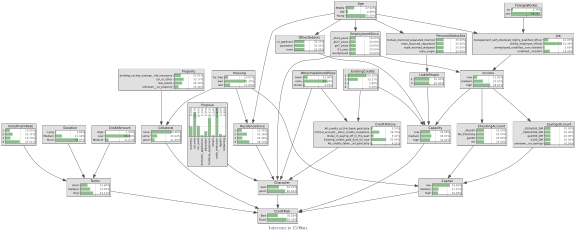

In [8]:
# Inference
gnb.showInference(bn)

In [9]:
# Before learning, filter vars_df to only BN variables
vars_df = vars_df[list(bn_vars)]

# Check if names match
print("BN names (sorted):", sorted(bn.names()))
print("DF columns (sorted):", sorted(vars_df.columns))
print("Match?", set(bn.names()) == set(vars_df.columns))

# Drop rows with NaN (BNLearner can't handle missing data)
vars_df = vars_df.dropna()
print(f"DataFrame shape after dropna: {vars_df.shape}")

# Learn parameters from the data - maintain predefined structure
learner = gum.BNLearner(vars_df, bn)

# Joint observations require us to use some form of smoothing to avoid zero probabilities
learner.useSmoothingPrior()  # Default weight=1.0; adds uniform prior to all CPT entries

learned_bn = learner.fitParameters(bn)

bn.saveBIF('BNs/GermanCreditLearned.bif')

BN names (sorted): ['Age', 'Capacity', 'Capital', 'Character', 'CheckingAccount', 'Collateral', 'CreditAmount', 'CreditHistory', 'CreditRisk', 'Duration', 'EmploymentSince', 'ExistingCredits', 'ForeignWorker', 'Housing', 'Income', 'InstallmentRate', 'Job', 'LiablePeople', 'OtherDebtors', 'OtherInstallmentPlans', 'PersonalStatusSex', 'Property', 'Purpose', 'ResidenceSince', 'SavingsAccount', 'Terms']
DF columns (sorted): ['Age', 'Capacity', 'Capital', 'Character', 'CheckingAccount', 'Collateral', 'CreditAmount', 'CreditHistory', 'CreditRisk', 'Duration', 'EmploymentSince', 'ExistingCredits', 'ForeignWorker', 'Housing', 'Income', 'InstallmentRate', 'Job', 'LiablePeople', 'OtherDebtors', 'OtherInstallmentPlans', 'PersonalStatusSex', 'Property', 'Purpose', 'ResidenceSince', 'SavingsAccount', 'Terms']
Match? True
DataFrame shape after dropna: (1000, 26)


# Creating Influence diagram


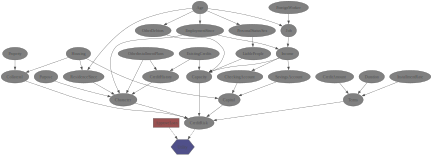

In [10]:
# Load the influnce diagram

influence_diagram = gum.loadID('credit_id.xml')
gnb.showInfluenceDiagram(influence_diagram)

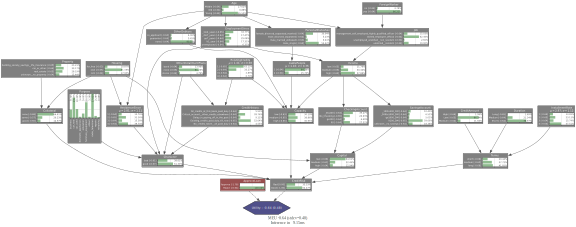

In [11]:
gnb.showInference(influence_diagram)

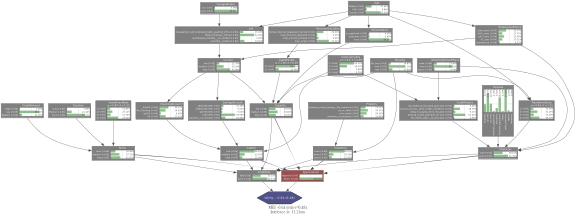

In [12]:
# Add the parents of credit risk to the action node

parents = bn.parents("CreditRisk")
decision_name = "ApproveLoan"

for parent in parents:
    parent_name = bn.variable(parent).name()
    influence_diagram.addArc(parent_name, decision_name)

gnb.showInference(influence_diagram)